<a href="https://colab.research.google.com/github/theouterlimitz/SDSS_Star_Classification/blob/main/02_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the clean, prepared dataset
df = pd.read_pickle('cleaned_sdss_data.pkl')

print("Cleaned dataset loaded successfully!")
df.info()

**Prepare Data for Machine Learning**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("--- Preparing Data for Machine Learning ---")

# 1. Separate features (X) and target (y)
X = df.drop(columns=['class']) # All columns except our target
y = df['class']               # Just the target column

# 2. Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Target labels encoded successfully.")
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# 3. Split the data into training and testing sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nData split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nFeatures scaled successfully.")

**Train and Evaluate Baseline Model (Random Forest)**

--- Training Random Forest Classifier ---
Model training complete.

--- Evaluating Model Performance ---
Accuracy Score: 0.9795

Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:


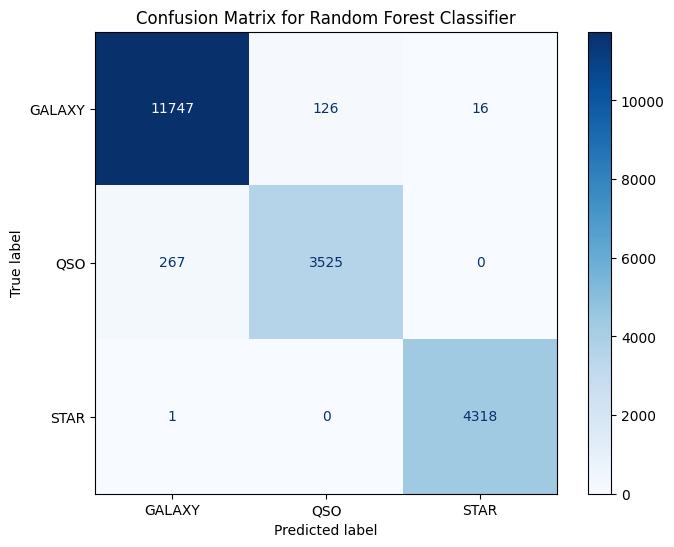


--- Analyzing Feature Importance ---


<ipython-input-3-2230167897>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette='mako')


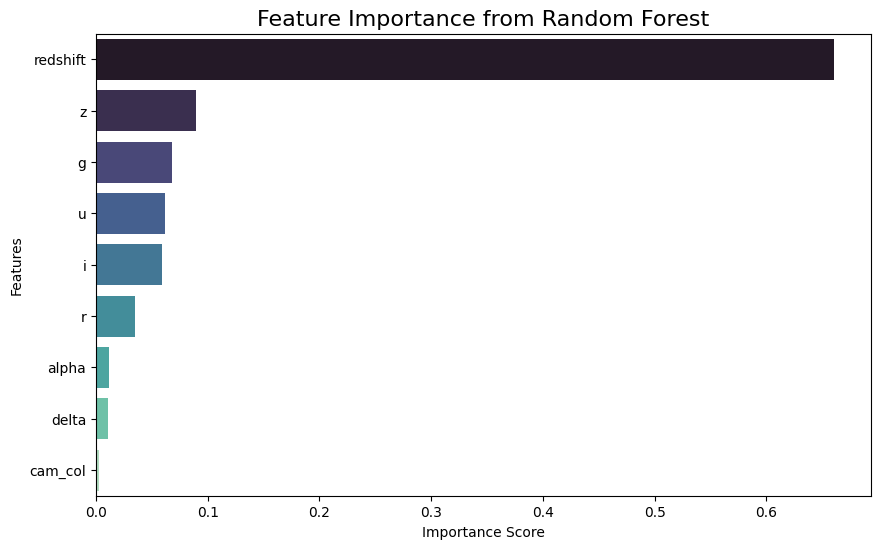

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Training Random Forest Classifier ---")

# 1. Initialize and Train the Model
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc.fit(X_train_scaled, y_train)
print("Model training complete.")

# 2. Make Predictions and Evaluate
print("\n--- Evaluating Model Performance ---")
y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# 3. Display Detailed Reports
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rfc, X_test_scaled, y_test,
                                      display_labels=label_encoder.classes_,
                                      cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

# 4. Analyze Feature Importance
print("\n--- Analyzing Feature Importance ---")
importances = rfc.feature_importances_
feature_importance_df = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette='mako')
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

**Building the Neural Network**

--- Building the Neural Network ---
Model built and compiled successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,715 (45.76 KB)

 Trainable params: 11,715 (45.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the Neural Network (this will take a few minutes) ---
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8380 - loss: 0.4023 - val_accuracy: 0.9567 - val_loss: 0.1446
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9447 - loss: 0.1699 - val_accuracy: 0.9613 - val_loss: 0.1235
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9523 - loss: 0.1502 - val_accuracy: 0.9631 - val_loss: 0.1168
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9566 - loss: 0.1353 - val_accuracy: 0.9644 - val_loss: 0.1121
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9576 - loss: 0.1360 - val_accuracy: 0.9657 - val_loss: 0.1066
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9600 - loss: 0.1272 - val_accuracy: 0.9670 - val_loss: 0.1058
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9620 - loss: 0.1222 - val_accuracy: 0.9679 - val_loss: 0.1058
Epoch 8/20
2000/2000 ━

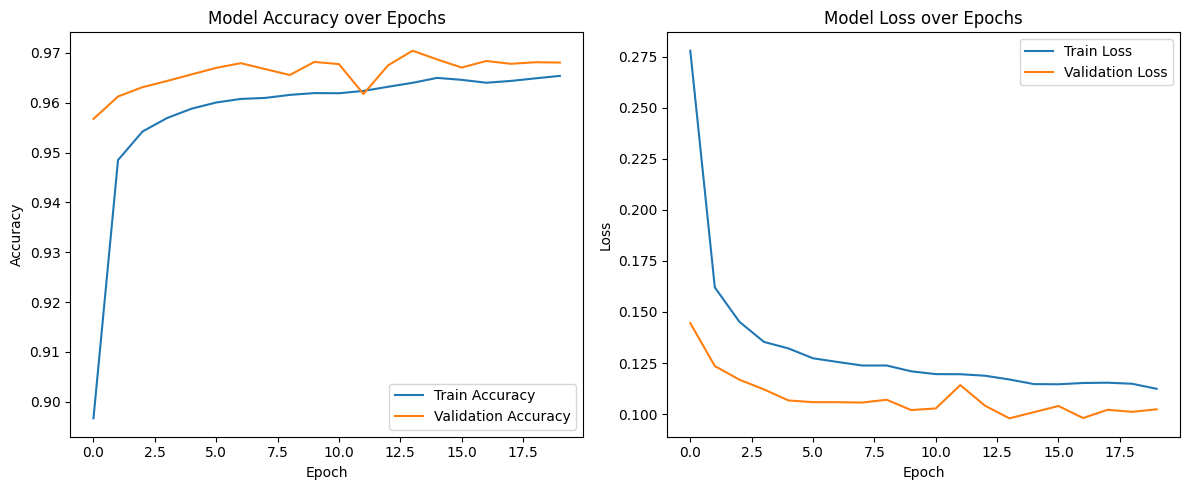


--- Evaluating Final Model Performance on Test Data ---
Final Test Accuracy: 0.9687
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step

Classification Report (Neural Network):
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     11889
         QSO       0.97      0.92      0.94      3792
        STAR       0.95      1.00      0.98      4319

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix (Neural Network):


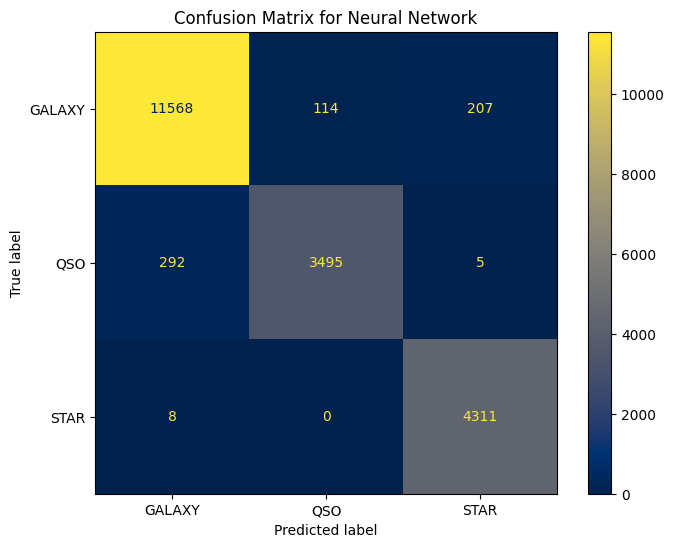

In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Assume these variables are loaded in your notebook's memory ---
# X_train_scaled, X_test_scaled, y_train, y_test
# label_encoder (for decoding labels later)

# ===================================================================
# --- Step 1: Build and Train the Neural Network ---
# ===================================================================
print("--- Building the Neural Network ---")

# Define the Model Architecture
model = keras.Sequential([
    # Input layer: The shape must match the number of features (9)
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.3),  # Dropout helps prevent overfitting

    # Hidden layer 1
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),

    # Hidden layer 2
    keras.layers.Dense(32, activation='relu'),

    # Output layer: It must have 3 neurons (one for each class)
    # 'softmax' is used for multi-class classification to output a probability for each class.
    keras.layers.Dense(3, activation='softmax')
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built and compiled successfully.")
model.summary()

# Train the Model
print("\n--- Training the Neural Network (this will take a few minutes) ---")
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,          # We'll do 20 passes through the training data
    batch_size=32,      # Process data in batches of 32
    validation_split=0.2, # Use 20% of training data for validation during training
    verbose=1           # Show the progress bar
)

# ===================================================================
# --- Step 2: Visualize Training History ---
# ===================================================================
print("\n--- Visualizing Training History ---")
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ===================================================================
# --- Step 3: Evaluate Final Performance on the Unseen Test Set ---
# ===================================================================
print("\n--- Evaluating Final Model Performance on Test Data ---")

# Evaluate the model on the test set to get final loss and accuracy
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Final Test Accuracy: {accuracy:.4f}")

# To generate a classification report and confusion matrix, we need predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report (Neural Network):")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
print("\nConfusion Matrix (Neural Network):")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes,
                                        display_labels=label_encoder.classes_,
                                        cmap='cividis',
                                        ax=ax)
plt.title('Confusion Matrix for Neural Network')
plt.show()

**Advanced Network**

--- Building Advanced Neural Network (V2) ---
Model V2 built and compiled successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,891 (179.26 KB)

 Trainable params: 45,891 (179.26 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Advanced Neural Network (this may take a bit longer) ---
Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8493 - loss: 0.3791 - val_accuracy: 0.9489 - val_loss: 0.1507
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9419 - loss: 0.1745 - val_accuracy: 0.9590 - val_loss: 0.1269
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9507 - loss: 0.1549 - val_accuracy: 0.9626 - val_loss: 0.1154
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9537 - loss: 0.1446 - val_accuracy: 0.9601 - val_loss: 0.1183
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9562 - loss: 0.1360 - val_accuracy: 0.9628 - val_loss: 0.1137
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9569 - loss: 0.1351 - val_accuracy: 0.9531 - val_loss: 0.1340
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9584 - loss: 0.1316 - val_accuracy: 0.9506 - val_loss: 0.1396
Epoch 8/30
2000/20

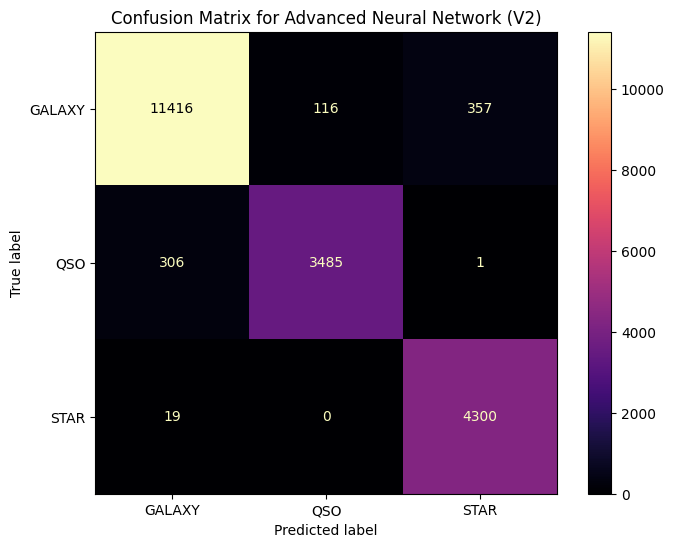

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Assume these variables are loaded in your notebook's memory ---
# X_train_scaled, X_test_scaled, y_train, y_test
# label_encoder (for decoding labels later)

# ===================================================================
# --- Step 7: Build, Train, and Evaluate an Advanced Neural Network ---
# ===================================================================
print("--- Building Advanced Neural Network (V2) ---")

# 1. Define the New, Deeper Model Architecture
model_v2 = keras.Sequential([
    # Input layer, now wider
    keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.4), # Slightly increased dropout for a larger layer

    # Hidden layer 1, wider than before
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),

    # Hidden layer 2 (this is the same as our previous model)
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),

    # NEW Hidden layer 3 (making the network deeper)
    keras.layers.Dense(32, activation='relu'),

    # Output layer (remains the same)
    keras.layers.Dense(3, activation='softmax')
])

# 2. Compile the Model
model_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model V2 built and compiled successfully.")
model_v2.summary()

# 3. Train the New Model
print("\n--- Training Advanced Neural Network (this may take a bit longer) ---")
history_v2 = model_v2.fit(
    X_train_scaled,
    y_train,
    epochs=30,  # Let's train for a few more epochs as well
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


# ===================================================================
# --- Evaluate the Advanced Model ---
# ===================================================================
print("\n--- Evaluating Final V2 Model Performance on Test Data ---")

# Evaluate the model on the test set
loss_v2, accuracy_v2 = model_v2.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Final Test Accuracy (Model V2): {accuracy_v2:.4f}")

# Generate a Classification Report
y_pred_probs_v2 = model_v2.predict(X_test_scaled)
y_pred_classes_v2 = np.argmax(y_pred_probs_v2, axis=1)

print("\nClassification Report (Neural Network V2):")
print(classification_report(y_test, y_pred_classes_v2, target_names=label_encoder.classes_))

# Generate a Confusion Matrix
print("\nConfusion Matrix (Neural Network V2):")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes_v2,
                                        display_labels=label_encoder.classes_,
                                        cmap='magma',
                                        ax=ax)
plt.title('Confusion Matrix for Advanced Neural Network (V2)')
plt.show()